# Heat flux in cylindrical mesh - Sample 2

In [23]:
from ngsolve import *
import matplotlib.pyplot as plt
import numpy as np
from netgen.read_gmsh import ReadGmsh
from calculations import *
from ngsolve.webgui import Draw


### Import and refine mesh

In [24]:
ngmesh = ReadGmsh("../Mesh/InfCyl5mm")

mesh = Mesh(ngmesh)
mesh.GetBoundaries()
for i in range(1):
    mesh.Refine()

Draw(mesh)
print(mesh.GetBoundaries())

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

('bottom', 'baby', 'bag', 'top')


### Parameters

In [25]:
D = (67.5*2+2*5)*1e-3

T_ambient = 4.7
Ts = 20.1
T_baby = 34


k = 0.048 # -> burde også ha +-0.002
eps = 0.80


h_rads = get_h_rad(Ts,T_ambient, eps)
h_convs = get_h_conv(D, Ts, T_ambient)
h = h_rads + h_convs
print("h_conv =", h_convs)
print("h_rad =", h_rads)

h_conv = 4.055125080924974
h_rad = 4.227612839258759


### Perform finite element

In [26]:

#define finite element space and trial and test functions
fes = H1(mesh, order = 3, dirichlet = "baby")
u = fes.TrialFunction()
v = fes.TestFunction()

# robin bc introduced in the biliniar and linear term of the equation - > here one baby bc is dirichlet and outer is robin 
a = BilinearForm(k*grad(u)*grad(v)*dx + h*u*v*ds("bag")).Assemble()
f = LinearForm(h*T_ambient*v*ds("bag")).Assemble()

#print(f.vec)

gfu = GridFunction(fes)
#apply dirichlet bnd_cond:
bc_vals = {"baby": T_baby, "bag": T_ambient, "top": None, "bottom":None}

boundaries = CoefficientFunction([bc_vals[mat] for mat in mesh.GetBoundaries()])
gfu.Set(boundaries,definedon=mesh.Boundaries("baby|bag"))


#Draw(gfu)

#calculate
res = f.vec - a.mat * gfu.vec
gfu.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * res

Draw (gfu)


#analyze flux
W, Area_inner, W_per_m2 = get_heat_loss(mesh, gfu, h_rads,h_convs, T_ambient)
                
print(f"Total heat loss W = {W:.3f} W")
print(f"Inner surface area= {Area_inner:.6f} m²")
print(f"Heat flux per unit area = {W_per_m2:.3f} W/m²")


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Total heat loss W = 17.504 W
Inner surface area= 0.127212 m²
Heat flux per unit area = 137.600 W/m²


### Exploring the emissivity

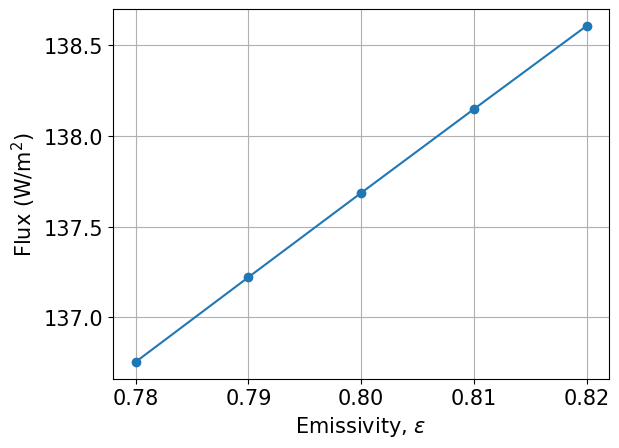

In [22]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 15})
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

eps_list = [ 0.78, 0.79, 0.80, 0.81, 0.82]

Flux = [136.754, 137.221, 137.686, 138.148, 138.607]
plt.plot(eps_list, Flux, "-o")
plt.xlabel(r'Emissivity, $\epsilon$')
plt.ylabel(r"Flux (W/m$^2$)")
plt.grid(True)
plt.show()

### Save result to paraview

In [7]:
vtk = VTKOutput(ma=mesh, coefs=[gfu], names=["temperature"], filename="../paraview/InfCyl5mm", subdivision=3)
vtk.Do()

'../paraview/InfCyl5mm'